In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from datetime import datetime 
import scipy as sp
from scipy.integrate import trapz

In [2]:
# read the parameters for the 2/11/22


delays = pd.read_parquet('/home/elamb/lsa_test/lumi-followup/examples/nx2pd/delays.parquet')
params = pd.read_parquet('/home/elamb/lsa_test/lumi-followup/examples/nx2pd/params.parquet')

In [22]:
def read_file(file_path, logger):
    """Loads data from file"""
    import numpy as np
    from pathlib import Path

    error_flag = False
    fid = open(file_path, 'r')
    if fid == -1:
        errstr = 'Cannot open the file: ' + file_path
        print(errstr)
        error_flag = True
    else:
        # Read header
        from_scope = {'delta_t_traces': '---', 'first_trigger': '---', 'tr_offset': []}
        for header_long, line in enumerate(fid):
            aux = line.split('* Date:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['date'] = aux

            aux = line.split('* Time:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['time'] = aux

            aux = line.split('* Time between traces:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                if aux == '---':
                    continue
                from_scope['delta_t_traces'] = int(aux[0])

            aux = line.split('* First trigger:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                if aux == '---':
                    continue
                from_scope['first_trigger'] = float(aux[0])

            aux = line.split('* Time interval per data point (sec):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['delta_t_pts'] = float(aux)

            aux = line.split('* Horizontal fastframe length:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['h_frame_length'] = int(aux)

            aux = line.split('* Number of frames:  ')
            if len(aux) != 1:
                aux = aux[1]
                n_frames = int(aux)
                from_scope['n_frames'] = n_frames

            aux = line.split('* Number of data points:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['n_data_pts'] = int(aux)

            aux = line.split('* Acquire mode:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['acq_mode'] = aux

            aux = line.split('* Filter:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['filter'] = aux

            aux = line.split('* Trigger holdoff time:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['tr_hold_off'] = aux

            aux = line.split('* Vertical scale (V/div):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_scale'] = float(aux)

            aux = line.split('* Vertical position (div):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_pos'] = float(aux)

            aux = line.split('* Input coupling:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['in_coupl'] = aux

            aux = line.split('* Input impedance:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['in_imp'] = aux

            aux = line.split('* Vertical bandwidth:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_bandwidth'] = float(aux)

            aux = line.split('* Scale Factor (dB):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['att_db'] = float(aux)

            aux = line.split('* Trigger offset (index sec):  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.split()
                from_scope['tr_offset'].append(float(aux[1]))
                header_end = header_long
                if len(from_scope['tr_offset']) == from_scope['n_frames']:
                    break
        fid.close()
        from_scope['tr_offset'] = np.array(from_scope['tr_offset'])

        # Read both numpy and ascii files
        if Path(file_path[:-3] + 'npy').exists():
            data = np.load(file_path[:-3] + 'npy')
        else:
            data = pd.read_csv(file_path, skiprows=header_end + 2, header=None)
            # This is for some old files where the zeros were not loaded properly
            data.replace({'0.000E+': '0'}, inplace=True)
            data = data.iloc[:, 0].astype(float)
            data = data.to_numpy()

        from_scope['acquired'] = np.reshape(data, (int(from_scope['h_frame_length']),
                                                    int(from_scope['n_frames'])), order='F')

        #if not error_flag:
        #    from_scope = Acquisition.add_timescale(from_scope, logger)

    return from_scope





def calculate_intensity(aux, lower, upper, plot=True):
    total_intensity = []
    for i in range(aux['n_frames']):
        total_intensity.append(trapz(aux['acquired'][lower:upper,i])) # only the first batch 
    if plot==True:
        plt.plot(total_intensity, label='Total Intensity all bunches in batch 1')
        plt.grid()
        plt.ylabel('Intensity')
        plt.legend()
        plt.xlabel('ms')
        plt.tight_layout()
        plt.show()
    return total_intensity 


def flat_values(data, thresh):
    data_flat = np.zeros(data.size)
    for i in np.arange(data.size):
        if  data[i] < thresh:
            data_flat[i] = 0
        else: 
            data_flat[i] = data[i]
    return data_flat

def calculate_intensity_flat(flat,lower, upper, plot=True):
    total_intensity = []
    total_intensity.append(np.sum(flat[lower:upper])) # only the first batch 
    
    if plot==True:
        plt.plot(total_intensity, label='Total Intensity all bunches in batch 1')
        plt.grid()
        plt.ylabel('Intensity')
        plt.legend()
        plt.xlabel('ms')
        plt.tight_layout()
        plt.show()
    return total_intensity 

In [23]:
aux=read_file('MD_135.asc', 'MD_135.npy')


flat0 = flat_values(aux['acquired'][0:51000,0], 0.003)
flatend = flat_values(aux['acquired'][0:51000,-1], 0.003)




In [28]:
print(np.sum(flatend))
print(np.sum(flat0))
print(np.sum(aux['acquired'][0:51000,0]))
print(np.sum(aux['acquired'][0:51000,-1]))


635.4744000000001
688.8728
487.68640000000005
437.936


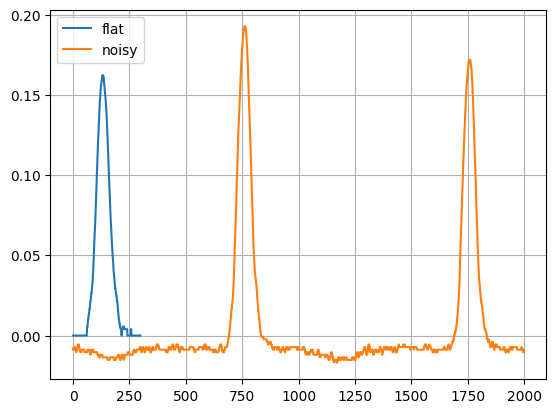

In [29]:
#plt.plot(flat0[2700:3000])
plt.plot(flatend[2700:3000], label='flat')
#plt.plot(aux['acquired'][2700:3000,0])
plt.plot(aux['acquired'][48000:50000,-1], label='noisy')
plt.grid()
plt.legend()

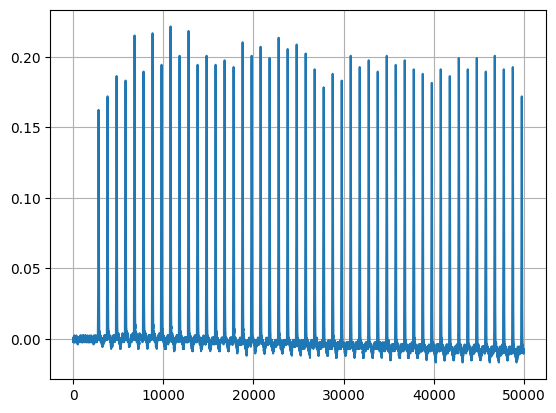

In [31]:
plt.plot(aux['acquired'][0:50000,-1], label='noisy')
plt.grid()


In [116]:
h = 12
i = 17


timestamp_p = (params.__record_timestamp__[h])
timestamp_d = (delays.__record_timestamp__[i])

trim_id_p = (params.trim_id[h])
trim_id_d = (delays.trim_id[i])
#dt_object = datetime.fromtimestamp(timestamp, )
#dt_object


print('params ', pd.Timestamp(timestamp_p, unit='ns'), trim_id_p)
print('delay ', pd.Timestamp(timestamp_d, unit='ns'), trim_id_d)

params  2022-11-02 15:09:33.727000 123597237
delay  2022-11-02 15:10:34.362000 123597300


In [117]:
pd.Timestamp(1667401834362000000)

Timestamp('2022-11-02 15:10:34.362000')

In [118]:
print(params.iloc[h])

print(params.value[h]["elements"].reshape(4,64))
print(delays.iloc[i])

__record_timestamp__                                  1667401773727000000
__record_version__                                                      1
context                                              LHC_BCMS_Q20_2022_V2
context_family                                                      CYCLE
context_id                                                          22182
parameter                             ScopeTriggerE/NormalMode#paramTable
parameter_id                                                      2019672
partition                                                       partition
trim_id                                                         123597237
value                   {'dimensions': [4, 64], 'elements': [44, 0, 0,...
nxcals_entity_id                                                 55335337
Name: 12, dtype: object
[[  44    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  

In [119]:
aux=read_file('MD_135.asc', 'MD_135.npy')

aux




{'delta_t_traces': '---',
 'first_trigger': '---',
 'tr_offset': array([6.1963e-12, 1.3946e-11, 3.4463e-12, ..., 1.4196e-11, 1.8196e-11,
        2.0696e-11]),
 'date': '2022-11-02',
 'time': '16:34:20',
 'delta_t_pts': 2.5e-11,
 'h_frame_length': 60000,
 'n_frames': 5500,
 'n_data_pts': 330000000,
 'acq_mode': 'SAMPLE',
 'filter': 'SINX',
 'tr_hold_off': 'RANDOM;250.0000E-9',
 'v_scale': 0.04,
 'v_pos': -4.5,
 'in_coupl': 'DC',
 'in_imp': '50.0000',
 'v_bandwidth': 2500000000.0,
 'att_db': 0.0,
 'acquired': array([[-0.0008,  0.0024, -0.0008, ..., -0.0008,  0.0008, -0.0008],
        [-0.0008,  0.0024, -0.0008, ..., -0.0008, -0.0008,  0.0008],
        [-0.0008,  0.0024, -0.0008, ..., -0.0008, -0.0008,  0.0008],
        ...,
        [-0.0088, -0.0104, -0.0088, ..., -0.0104, -0.0104, -0.012 ],
        [-0.0104, -0.0104, -0.0088, ..., -0.0104, -0.012 , -0.012 ],
        [-0.0104, -0.0088, -0.0088, ..., -0.0104, -0.012 , -0.0104]])}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


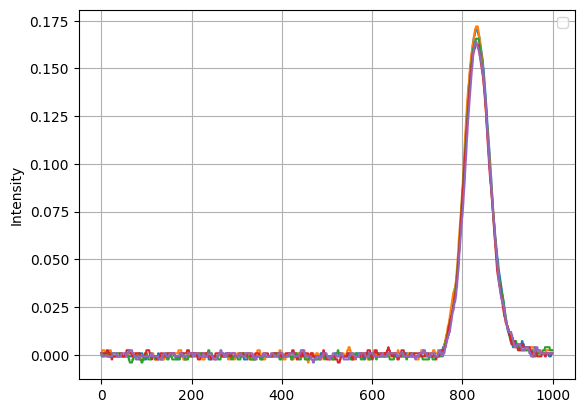

In [120]:

plt.plot(aux['acquired'][2000:3000,0],)

plt.plot(aux['acquired'][2000:3000,1000])

plt.plot(aux['acquired'][2000:3000,2000])

plt.plot(aux['acquired'][2000:3000,3000])


plt.plot(aux['acquired'][2000:3000,5299])
plt.grid()
plt.ylabel('Intensity')
plt.legend()


# Integrate for the bunch length and the intensity reduction ... 



# now you have the scraping on earlier... later on i am not sure ... 


In [121]:

flat = flat_values(aux['acquired'][0:51000][1], 0.005)



array([0., 0., 0., ..., 0., 0., 0.])

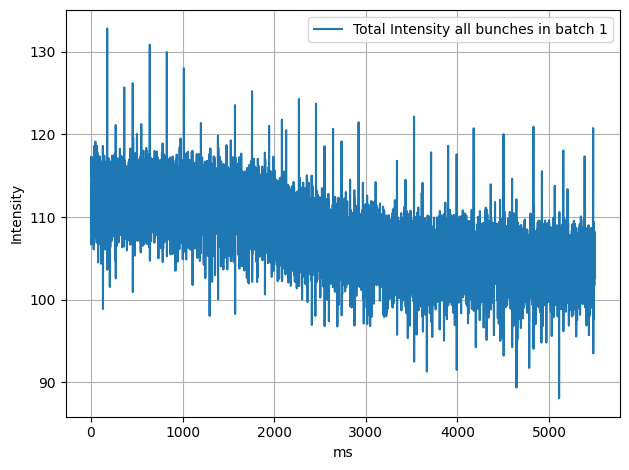

In [126]:
intensity = calculate_intensity(aux, 0,10000) # you need the FBCT per batch
#bunch_length = caluclate_bunch_length(aux) # can compare with the awblm at the same timestamp 


In [123]:
aux

{'delta_t_traces': '---',
 'first_trigger': '---',
 'tr_offset': array([6.1963e-12, 1.3946e-11, 3.4463e-12, ..., 1.4196e-11, 1.8196e-11,
        2.0696e-11]),
 'date': '2022-11-02',
 'time': '16:34:20',
 'delta_t_pts': 2.5e-11,
 'h_frame_length': 60000,
 'n_frames': 5500,
 'n_data_pts': 330000000,
 'acq_mode': 'SAMPLE',
 'filter': 'SINX',
 'tr_hold_off': 'RANDOM;250.0000E-9',
 'v_scale': 0.04,
 'v_pos': -4.5,
 'in_coupl': 'DC',
 'in_imp': '50.0000',
 'v_bandwidth': 2500000000.0,
 'att_db': 0.0,
 'acquired': array([[-0.0008,  0.0024, -0.0008, ..., -0.0008,  0.0008, -0.0008],
        [-0.0008,  0.0024, -0.0008, ..., -0.0008, -0.0008,  0.0008],
        [-0.0008,  0.0024, -0.0008, ..., -0.0008, -0.0008,  0.0008],
        ...,
        [-0.0088, -0.0104, -0.0088, ..., -0.0104, -0.0104, -0.012 ],
        [-0.0104, -0.0104, -0.0088, ..., -0.0104, -0.012 , -0.012 ],
        [-0.0104, -0.0088, -0.0088, ..., -0.0104, -0.012 , -0.0104]])}